# FEM Fwd Modelling

This notebook is to generate a Fwd model using a FEM solver

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from mpi4py import MPI
from dolfinx import mesh, fem, plot
import dolfinx.fem.petsc
import ufl
from petsc4py import PETSc
import gmsh
import basix

import pyvista

In [1]:
import dolfinx
import ufl
from mpi4py import MPI
import numpy as np

gdim = 2
shape = "triangle"
degree = 1


cell = ufl.Cell(shape, geometric_dimension=gdim)
domain = ufl.Mesh(ufl.VectorElement("Lagrange", cell, degree))

x = np.array([[0.5, 1], [2, 1], [3, 1.5], [3.5, 2.5], [2.2, 2], [1, 2.2]])
cells = np.array([[0, 1, 5], [1, 4, 5], [1, 2, 4], [2, 3, 4]], dtype=np.int32)
mesh = dolfinx.mesh.create_mesh(MPI.COMM_WORLD, cells, x, domain)

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)

TypeError: Cell.__init__() got an unexpected keyword argument 'geometric_dimension'

In [12]:
%matplotlib widget

In [6]:
# Mesh Generation
# https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_gmsh.html
# https://jsdokken.com/dolfinx-tutorial/chapter1/membrane_code.html
# https://jsdokken.com/dolfinx-tutorial/chapter3/em.html
# https://fenicsproject.discourse.group/t/create-mesh-in-fenicsx-from-point-and-element-array/9092

# First load the mat file which contains all the data. 

filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/R-Upper-Arm_Segmented_WithNames_And_FCU_And_Skin.mat'

mat = scipy.io.loadmat(filename)

In [11]:
mesh.CellType.triangle

dolfinx.cpp.mesh.CellType.triangle

In [14]:
# domain = ufl.Mesh(ufl.VectorElement("Lagrange", ufl.triangle, 1)) # 3rd argument is degree, which I am not sure what it does. 
# basix.ufl.element("Lagrange", , degree, shape=(N,))
arm_mesh = mesh.create_mesh(MPI.COMM_WORLD, mat['faces'], mat['vertices'], mesh.CellType.triangle)

AttributeError: 'dolfinx.cpp.mesh.CellType' object has no attribute 'dtype'

In [16]:
print(mat['vertexNormals'].shape)
print(mat['vertices'].shape)
print(mat['faces'].shape)

(121266, 3)
(121266, 3)
(202872, 3)


In [26]:
faces[0]

array([16,  9,  1], dtype=int32)

In [23]:
vertices = mat['vertices']
faces = mat['faces']

# Initialize Gmsh
gmsh.initialize()
gmsh.model.add("surface_mesh")

# Define vertices
for i, v in enumerate(vertices):
    gmsh.model.geo.addPoint(v[0], v[1], v[2], 1, i + 1)

# Define triangular faces
# for i, f in enumerate(faces):
#     gmsh.model.geo.addCurveLoop([f[0], f[1], f[2]], i + 1)
#     print(i+1)
#     gmsh.model.geo.addPlaneSurface([i + 1], i + 1)
#     print(i+1)

# Synchronize and generate mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)  # For surface meshes (2D)

# Save mesh as msh file (can be loaded into FEniCSx)
gmsh.write("surface_mesh.msh")

gmsh.finalize()

Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 8.1416e-05s, CPU 1.9e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 5.075e-05s, CPU 2e-05s)
Info    : 121266 nodes 121266 elements
Info    : Writing 'surface_mesh.msh'...
Info    : Done writing 'surface_mesh.msh'


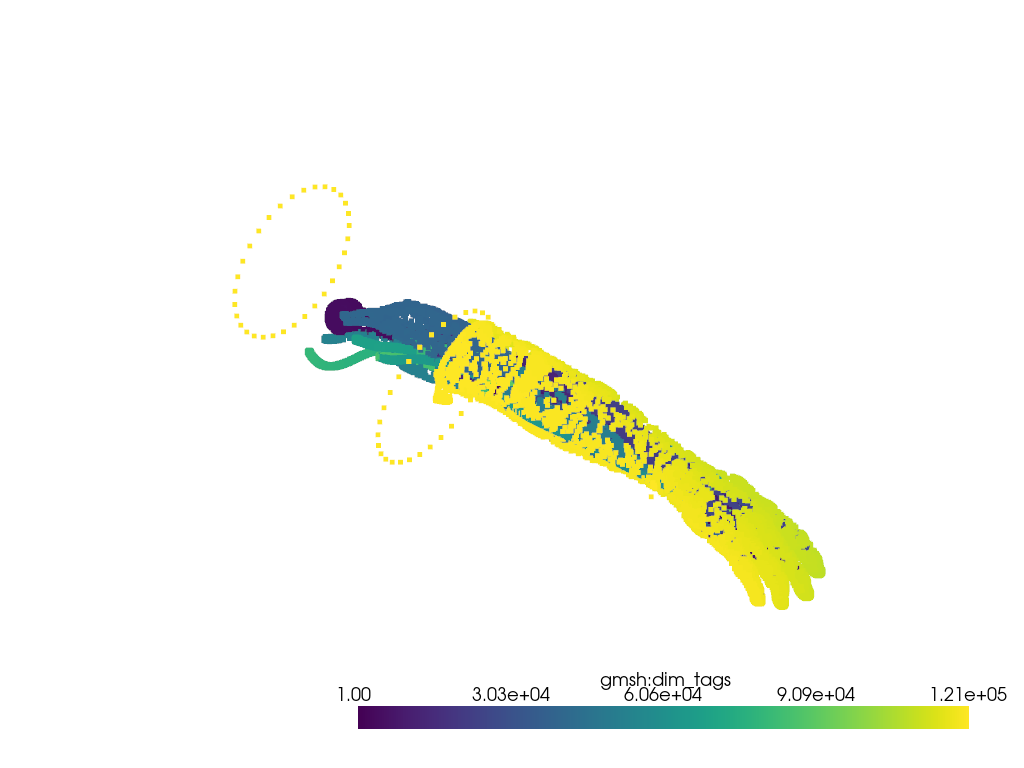

In [24]:
# Load a mesh file (replace with your file path)
mesh = pyvista.read("surface_mesh.msh")  # Gmsh .msh file or .vtk

# Plot the mesh
plotter = pyvista.Plotter()
plotter.add_mesh(mesh, show_edges=True)
plotter.show()

In [ ]:
1/0

In [5]:
# Create mesh (Unit square domain)
domain = mesh.create_unit_square(MPI.COMM_WORLD, 50, 50)

# Define function space (Continuous Galerkin, degree 1)
V = fem.functionspace(domain, ("CG", 1))

In [9]:
domain = mesh.create_mesh(MPI.COMM_WORLD, mat['vertices'], mat['faces'])

TypeError: create_mesh() missing 1 required positional argument: 'e'

In [13]:
# Create mesh (Unit square domain)
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

# Define function space (Continuous Galerkin, degree 1)
# V = fem.functionspace(domain, ("CG", 1))
V = fem.functionspace(domain, ("Lagrange", 1))

# Define boundary condition (Dirichlet boundary condition, phi = 0 on boundary)
u_bc = fem.Function(V)
with u_bc.vector.localForm() as loc:
    loc.set(0.0)

boundary_facets = mesh.locate_entities_boundary(domain, 1, lambda x: np.full(x.shape[1], True))
bc = fem.dirichletbc(u_bc, fem.locate_dofs_topological(V, 1, boundary_facets))

# Define dipole source (using a Gaussian function)
class DipoleSource:
    def __init__(self, x0, strength=10.0):
        self.x0 = np.array(x0)
        self.strength = strength

    def __call__(self, x):
        r = np.linalg.norm(x - self.x0[:, np.newaxis], axis=0)
        return self.strength * np.exp(-100 * r**2)

# Instantiate dipole source centered at (0.5, 0.5)
dipole = DipoleSource([0.5, 0.5])

# Define the source function (charge density, rho)
rho = fem.Function(V)

In [15]:
rho.interpolate(dipole)

# Define the variational problem (Poisson's equation)
u = ufl.TrialFunction(V)  # Trial function (solution)
v = ufl.TestFunction(V)   # Test function

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx  # Left-hand side (LHS)
L = rho * v * ufl.dx                           # Right-hand side (RHS)

# Assemble system
A = fem.petsc.assemble_matrix(fem.form(a), bcs=[bc])
A.assemble()
b = fem.petsc.assemble_vector(fem.form(L))
fem.apply_lifting(b, [fem.form(a)], bcs=[[bc]])
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
fem.set_bc(b, [bc])

# Solve system
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)
solver.getPC().setType(PETSc.PC.Type.ICC)
solver.setTolerances(rtol=1e-8)

u_sol = fem.Function(V)
solver.solve(b, u_sol.vector)


ValueError: operands could not be broadcast together with shapes (3,600) (2,1) 

KeyboardInterrupt: 

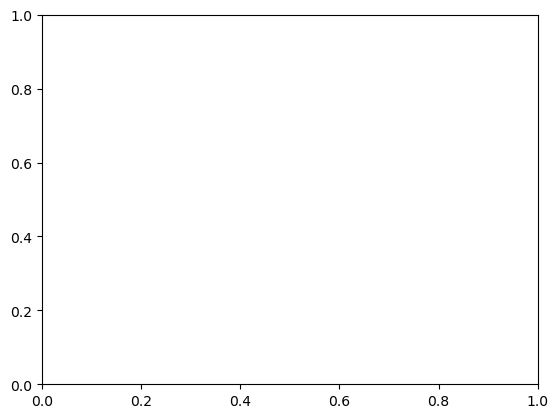

In [8]:
# Visualize the solution
fig, ax = plt.subplots()
plt.plot(u_sol, cmap="viridis", ax=ax)
ax.set_title("Electric Potential Generated by a Dipole")
plt.show()

In [ ]:
# # Save solution in VTK format for Paraview
# with fem.io.XDMFFile(MPI.COMM_WORLD, "electric_potential.xdmf", "w") as xdmf:
#     xdmf.write_mesh(domain)
#     xdmf.write_function(u_sol)